# ==============================
# 📈 LSTM Stock Price Prediction (PLTR)
# ==============================


In [2]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 23.4 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.8 MB/s  0:00:00
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15548 sha256=fd1d8c23083611a154a1845309d524cd384540dca8219544e130fe4c636bc685
  Stored in directory: /Users/bipinpand

In [1]:
# Step 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Step 2. Download PLTR data
ticker = 'PLTR'
data = yf.download(ticker, start='2020-01-01', end='2025-10-01')
print("Data shape:", data.shape)
data.tail()

/var/folders/9v/9dcjztmd5kxffqw73qlg37l40000gn/T/ipykernel_56609/2921085502.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2025-10-01')
[*********************100%***********************]  1 of 1 completed

Data shape: (1256, 5)


Price,Close,High,Low,Open,Volume
Ticker,PLTR,PLTR,PLTR,PLTR,PLTR
Date,,,,,
2025-09-24,179.559998,184.850006,177.119995,183.910004,45379700
2025-09-25,179.119995,184.320007,174.289993,175.800003,72321200
2025-09-26,177.570007,180.119995,174.910004,179.050003,44275800
2025-09-29,178.860001,181.479996,177.160004,179.639999,38413800
2025-09-30,182.419998,182.770004,178.220001,178.979996,43561700


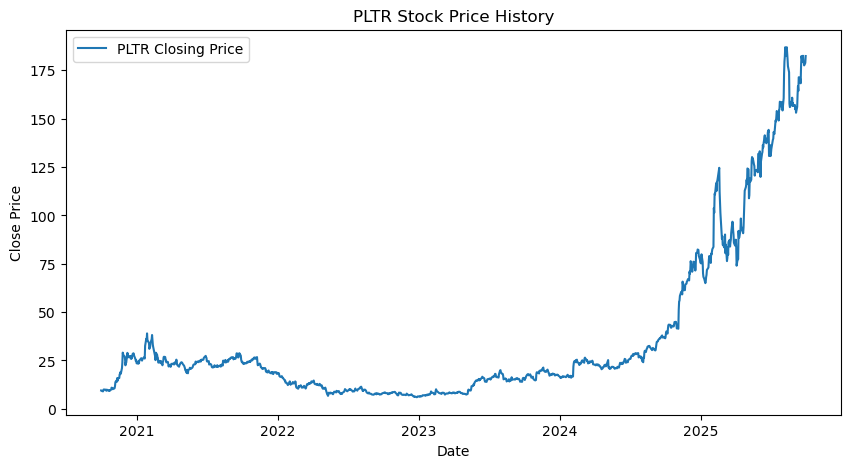

In [3]:
# Step 3. Prepare closing price data
close_data = data[['Close']]
plt.figure(figsize=(10,5))
plt.plot(close_data, label='PLTR Closing Price')
plt.title('PLTR Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [4]:
# Step 4. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [5]:
# Step 5. Train-test split (80/20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [6]:
# Step 6. Create sequences for LSTM
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [7]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (944, 60, 1)
X_test shape: (252, 60, 1)


In [8]:
# Step 7. Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/miniconda3/envs/ztdltest/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 8. Train model
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1, verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.8809e-04 - val_loss: 2.0046e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7614e-04 - val_loss: 1.9231e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4815e-04 - val_loss: 2.0787e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3094e-04 - val_loss: 2.2087e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3367e-04 - val_loss: 1.2750e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2703e-04 - val_loss: 1.7630e-04
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2442e-04 - val_loss: 1.9833e-04
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0203e-04 - val_loss: 1.8511e-04
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1078e-04 - val_loss: 1.5025e-04
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0804e-04 - val_

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


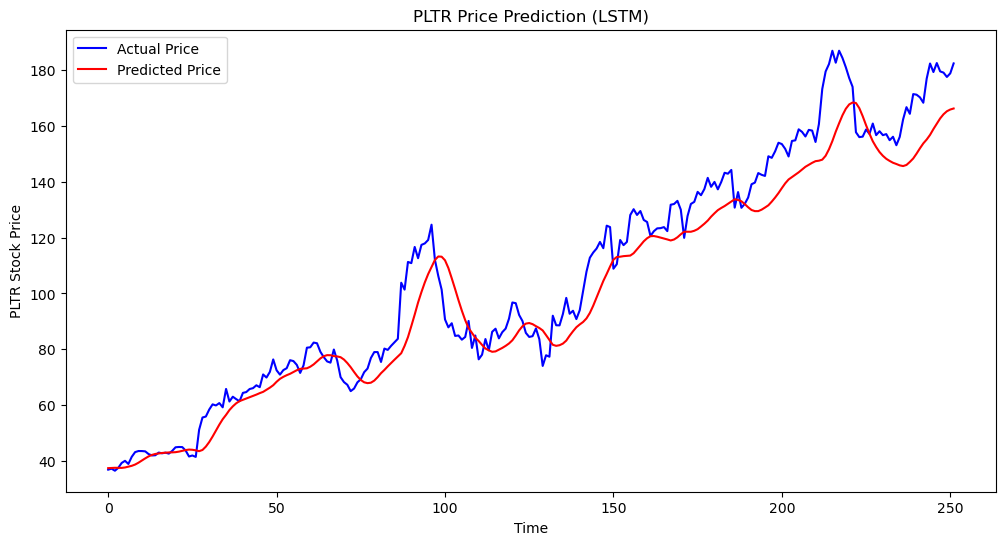

In [10]:
# Step 9. Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 10. Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title('PLTR Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('PLTR Stock Price')
plt.legend()
plt.show()

In [11]:
# Step 11. Evaluate
rmse = np.sqrt(np.mean((predictions - y_test_actual)**2))
print("RMSE:", rmse)


RMSE: 11.15701531846105


In [12]:
# Step 12. Predict next day price
last_60_days = scaled_data[-60:]
X_future = np.array([last_60_days])
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))

next_day_scaled = model.predict(X_future)
next_day_price = scaler.inverse_transform(next_day_scaled)
print(f"Predicted next day closing price for PLTR: ${next_day_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted next day closing price for PLTR: $166.70
